##SparseNet models for Keras.
### Reference
- [Sparsely Connected Convolutional Networks](https://arxiv.org/abs/1801.05895)
- [Github](https://github.com/lyken17/sparsenet)
- [Cyclical Learning Rates for Training Neural Networks
](https://arxiv.org/abs/1506.01186)

###Skip Connections:
---
<div align="justify">Predicting detail information of complicated visual scene may require understanding it at multiple levels abstraction, from edges and textures to object categories. As we all know convolution neural network learns increasingly abstract visual representations when going to deeper layers. But training such  deep networks requires back-propogating a signal through all the layers of the given networks which results in loss at the end of network to be noisier due to deeper layers and it becomes worst has we go deep and we also need to store and maintain a feature computed early that network need to reuse, to overcome this we use skip connections which connect multiple outputs from different layer to $l_{th}$ layer which can provide a pathway for assembling  feature that  combines many level of abstraction</div>

### Optimizer:
___

The choice of optimization algorithm indicates how fast  and optimum is your model.  To train a model we need to reduce the loss which is a functon of weight and bias. With the help of back propogation we back propogate the current error in the previous layer and modify the weights and bias such a way that the error is reduced. To modify weights we use optimization algorithm.

Optimization function is usually use to calculate gradiant i.e. the partial derivative of loss function with respect to weights and weghts are modified in opposite direction of calculate gradient. This i cycle is repeated until we reach minima of loss function

To reduce the loss and modify the weights we use hyper parameter learning rate which can be tuned to get optimal results. Choosing a proper learning rate is difficult. If the learning rate is too low it result in slow convergence and may lead to vanishing gradient descent  and if it is to high it may diverge from the minmal and may leading exploding gradient problem




### Why Sparsenet : 
___
<div align="justify">SparseNet is a variant of DenseNets or Resnet. In Densenet we  have a skip connection after every block which are concatenated to next layer and in resnet we do cumulative summation, but both have same problems i.e. as the depth increases, the number of features grows linearly. Later features may corrupt or wash out the information carried by earlier features maps as seen in resnet which result in saturation of resnet performance, in contrast densnet preserves the original format of previous layers due to concatenation, this factor contribute to better parameter performance efficiency over resnet but due to concatenation no of parameters grows at the rate of $0(N^2)$ due to which portion of network is devoted to process previously seen feature map and hence are not able to exploit all the parameters fully and this pitfall are due to the linear growth of feature maps in both densnet and resnet. To overcome this we would like to maintain the power of short gradient paths for training. By aggregating features only from layers with exponential offset the length of the shortest  gradient path between blocks with offset S is bounded  by  $O((c-1)log(S))$. Here, c is again the base of the exponent governing the sparse connection pattern. The total number of output to the $l^{th}$ block is $O(log(l))$ due to exponential offsets. Therefore total no of skip connections is</div>

<center>$\sum_{l=1}^N(log_cl) = O(NlogN)$</center>

<center>N is the number of basic blocks (depth) of the network. </center>

<center>The number of parameters are $O(N log N)$ and $O(N)$, respectively, for aggregation by concatenation and aggregation by summation</center>

<div align="justify">SparseNets have such skip connections only at depths of $2^N$. This allows model to be less memory intensive due to less parameters while still performing equivalent to densnet or better</div>

<center>![alt text](https://lh3.googleusercontent.com/ar5begWFXAGXPVDeIORZB_iD4OrsAe6dR-yyfEjCNhR8fnt-LnnFcRDUrecj7era4845nS8iyolaWmN0GaTCo114I9WmTSTo0cTIGBQnVwzvJ9yrVa0Fm0TYUnxphcHbQC5pAoWe=w2400)</center>

<center>** Densnet/Resnet**</center>

<center>![alt text](https://lh3.googleusercontent.com/pJosUXvPpuMJu87oi0gb351VelsWpLkbcX6TXx5i1qh_QOaMEPgeJS-Ikg3Dilfue6qDNnfOblaOpc8BUJOzgY4yPE23QxOBttS268ojfYJajR7uBGg__cNisOUUIp0f-vNfx7zi=w2400)</center>

<center>![alt text](https://lh3.googleusercontent.com/EnnfenqM7PICFgtcfxgVO0PWJOCbpFFCCq0DDSRhBoZU63ZgZUzqAsGWx0tSZCbULSNwqfBDEr41Q0enZUJXAUON3j2s30aqosQZrrsgBHWHjWJpB4Xo5bBlm-NvmBkkXJNOTRMp=w2400)</center>
<center>** Sparsenet**</center>


##Experiments

<div align="justify">We demonstrate the effectiveness of SparseNets over DenseNets, through image classification tasks on the CIFAR-100 datasets</div>

We Implement our models in Keras

**Datasets**:
CIFAR both the CIFAR-10 and CIFAR-100 datasets have 50,000 training
images and 10,000 testing images with size of 32 × 32 pixels. CIFAR-10 
and CIFAR-100  have 10 and 100 classes respectively. Our experiments
use standard data augmentation

In [0]:
import numpy as np
import warnings
from scipy.misc import imresize, toimage
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, SeparableConv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model, convert_dense_weights_data_format
from keras.utils.data_utils import get_file
from keras.utils import np_utils

from keras.engine.topology import get_source_inputs
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import decode_predictions
from keras.callbacks import LearningRateScheduler
import keras.backend as K


import os.path
import sklearn.metrics as metrics
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

###Load Datasets

In [0]:
#load data
(trainX, trainY), (testX, testY) = cifar100.load_data()

nb_classes = len(np.unique(trainY))
nb_channels = trainX.shape[-1]

trainX = trainX.astype('float32')
testX = testX.astype('float32')

cifar_mean = trainX.mean(axis=(0, 1, 2), keepdims=True)
cifar_std = trainX.std(axis=(0, 1, 2), keepdims=True)

trainX = (trainX - cifar_mean) / (cifar_std + 1e-8)
testX = (testX - cifar_mean) / (cifar_std + 1e-8)

Y_train = np_utils.to_categorical(trainY, nb_classes)
Y_test = np_utils.to_categorical(testY, nb_classes)

### Hyper Parameters


In [0]:
dropout_rate = 0.0
growth_rate=24
compression = 0.5
depth = 40
bottleneck=False
weight_decay=1e-4

**Batch Normalization** : Use to normalize output of previous activation layer

**Relu** : Use to convert all the negative values to zero and positive values unchanged

**Conv2D**: Apply kernel with receptive field size of 3x3 with bias zero and padding same to maintain output feature map same as input feature map

**Dropout**: Reducing overfiitting by dropping few node randomly

**Bottleneck Layer** : To improve computational efficiency we can introduce bottleneck layer 3x3 convolution layer to reduce the no of feature maps

**Compression**:  We can also reduce feature maps in transition layer by introducing compression factor whose value lies between $0<\theta\le1$

###Exponential $2^N$
We consider skip connections only at depths of $2^N$.  

**input** : List of processed layers

**returns** : layers which are exponential of $2^N$

In [0]:
def _exponential_index_fetch(x_list):
    count = len(x_list)
    i = 1
    inputs = []
    while i <= count:
      inputs.append(x_list[count - i])
      i *= 2
    return inputs

###Convolution Layer with &amp; Wihtout Bottleneck Layer

###Parameters:

**Input**: previous layer output (ip), num of filter (nb_filter)

**Output** : current layer output (x)

**note**: Both bottleneck layer and dropout are conditional 

In [0]:
def add_conv_block(ip, nb_filter):
    
  concat_axis = -1

  x = BatchNormalization(axis=concat_axis, momentum=0.1, epsilon=1e-5)(ip)
  x = Activation('relu')(x)

  if bottleneck:
    # Obtained from https://github.com/liuzhuang13/DenseNet/blob/master/densenet.lua
    inter_channel = nb_filter * 4 

    x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=concat_axis, epsilon=1e-5, momentum=0.1)(x)
    x = Activation('relu')(x)

  x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)
  if dropout_rate > 0.0:
    x = Dropout(dropout_rate)(x)

  return x

### Dense Block

###Parameters:

**Input**: 

1.   previous layer output (ip)
2.   no of layers per dense block (nb_layers)
3. rate at which no of filter grow (growth_rate), grow filter exponentially               (grow_nb_filters)

**Output** : 
1. current layer output (x) 
2. no of filter (nb_filter)

###Explanation

In this function we create layers based on no of layers (nb_layers)  and concatenate  output layers from previous layers  which are $2^N$  exponential and also grow no of filter exponentially 


In [0]:
def add_dense_block(x, nb_layers, nb_filter):
    
    concat_axis = -1

    x_list = [x]
    channel_list = [nb_filter]

    for i in range(nb_layers):
      x = add_conv_block(x, growth_rate)
      x_list.append(x)

      fetch_outputs = _exponential_index_fetch(x_list)
      x = concatenate(fetch_outputs, axis=concat_axis)

      channel_list.append(growth_rate)

    nb_filter = sum(_exponential_index_fetch(channel_list))

    return x, nb_filter

###Transition Layer


###Parameters:

**Input**: 

1.   previous layer output (ip)
2. no of filters (nb_filter)
3. reduction ratio of transition layer (compression)

**Output** : 
1. current layer output (x) 

###Explanation

Use to reduce the no of feature maps after each dense block. This is use to control no of parameters that flow to next dense block for better computancy. Using compression we control the reduction ratio of transition layer

In [0]:
def add_transition_block(ip, nb_filter):
  concat_axis = -1
  x = BatchNormalization(axis=concat_axis, epsilon=1e-5, momentum=0.1)(ip)
  x = Activation('relu')(x)
  x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
             kernel_regularizer=l2(weight_decay))(x)
  x = AveragePooling2D((2, 2))(x)

  return x

###Create Sparsenet


###Parameters:

**Input**: 

1.   Image Input (img_input)
2.   total no of layer in the given sparsenet model (depth)
4. growth rate

**Output** : 
1. model output (x) 

###Explanation

Based on given depth we divide total no layers into layers in dense block, layer in transition layer and layer in bottleneck layer using the below formula we divide the layers into the given blocks and layers
<center>$Depth = 3N+4$</center>
**note**: by default we consider 3 dense block and last dense block doesn't have transition layer

We convert given no of dense block in our case 3 into a list and also growth rate into list remember both lost should be of dense block size

We assign nb_filter = growth rate for firstlayer which is a convolution layer of kerner receptive field size of 3x3 following this layers is our 3 dense block and 2 transition layer and bottleneck layers if true and finall y the output layer

In [0]:
def create_dense_net(img_input):
   
    global compression
    #channel_last
    concat_axis = -1
    #no of dense_block
    nb_dense_block=3

    # layers in each dense block
    assert (depth - 4) % nb_dense_block == 0, 'Depth must be 3 N + 4'
    count = int((depth - 4) / nb_dense_block)

    if bottleneck:
      count = count // 2
    else:
      compression = 1

    #convert int list
    nb_layers = [count for _ in range(nb_dense_block)]
    final_nb_layer = count

    # compute initial nb_filter
    nb_filter = 2 * growth_rate

    # Initial convolution
    x = Conv2D(nb_filter, (3,3), kernel_initializer='he_normal', padding='same', use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

    # Add dense blocks
    for i in range(nb_dense_block - 1):
        # add dense block
        x, nb_filter = add_dense_block(x, nb_layers[i], nb_filter)
        # add transition_block
        x = add_transition_block(x, nb_filter)
        nb_filter = int(nb_filter * compression)

    # The last dense_block does not have a transition_block
    x, nb_filter = add_dense_block(x, final_nb_layer, nb_filter)

    x = BatchNormalization(axis=concat_axis, epsilon=1e-5, momentum=0.1)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(nb_classes, activation='softmax')(x)

    return x

###Create Sparse Model
###parameters
**batch_size** :  The datasets which we use is cifar and consist of 50000 train and 10000 test images which we divide into no of batches with each batch size equal to 64 and total no of batches forms 1 epoch

In [0]:
def SparseNet(input_shape):
    
    inputs = Input(shape=input_shape)
    
    output = create_dense_net(inputs)
        
    # Create model.
    model = Model(inputs, output)
    return model

In [52]:
model = SparseNet((None,None,nb_channels))
print("Model created")

model.summary()

Model created
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, None, None, 4 1296        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_79 (BatchNo (None, None, None, 4 192         conv2d_79[0][0]                  
__________________________________________________________________________________________________
activation_79 (Activation)      (None, None, None, 4 0           batch_normalization_79[0][0]     
_______________________________________________________________________________________________

<b>Image Augmentation</b> If we consider example of dog image in given dataset and all dogs are facing left side then the model may not recognize all the dog facing right side after it its trained for good accuracy which may lead to overfiitting. To reduce over fitting and to improve accuracy we use image augmentation which genrates images from given datasets and produces more images with different angle and flips for better results and also we resize the images into smaller size  as the layers in the intial stages perfoms same pattern detection irrelevant of image size, therfore by reducing the size we can train our model faster and using less computation and then apply the result from this layers to images with large size

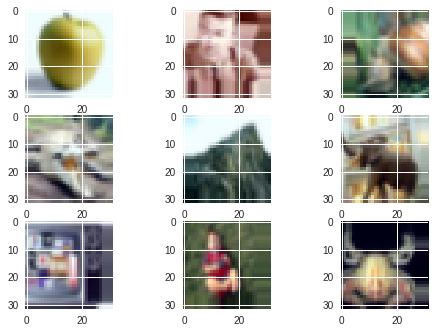

In [53]:
generator = ImageDataGenerator(width_shift_range=5. / 32,
                               height_shift_range=5. / 32,
                               horizontal_flip=True)

generator.fit(trainX, seed=0)

#Plot 
# Configure batch size and retrieve one batch of imagesxwd
for X_batch, y_batch in generator.flow(trainX, trainY, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break

### Cyclic Learning Rate
 <div align="justify">This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    <br><br>
    1. <b>triangular</b>: A basic triangular cycle w/ no amplitude scaling.<br>
    2. <b>triangular2</b>: A basic triangular cycle that scales initial amplitude by half each cycle.<br>
    3. <b>exp_range</b>: A cycle that scales initial amplitude by gamma (cycle iterations) at each 
        cycle iteration.<br></div>

### Arguments
  <br><b> base_lr</b>: initial learning rate which is the lower boundary in the cycle.
  <br><b>max_lr</b>: upper boundary in the cycle. Functionally, it defines the cycle amplitude (max_lr - base_lr). The lr at any cycle is the sum of base_lr and some scaling of the amplitude; therefore max_lr may not actually be reached depending on scaling function.
  <br><b>step_size</b>: number of training iterations per half cycle. Authors suggest setting step_size 2-8 x training iterations in epoch.
  <br><b>mode</b>: one of {triangular, triangular2, exp_range}. Default 'triangular'.  Values correspond to policies detailed above. If scale_fn is not None, this argument is ignored. 
  <br><b>gamma</b>: constant in 'exp_range' scaling function:  gamma**(cycle iterations)
  <br><b>scale_fn</b>: Custom scaling policy defined by a single argument lambda function, where 0 <= scale_fn(x) <= 1 for all x >= 0. mode paramater is ignored  
  <b>scale_mode:</b> {'cycle', 'iterations'}. Defines whether scale_fn is evaluated on cycle number or cycle iterations (training iterations since start of cycle). Default is 'cycle'.</div>

In [0]:
from keras.callbacks import *
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000, mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


### Experiment

<div align="justify">**Objective:** Create a model using <b><i>Sparsenet</i></b> architecture and train the model on <i><b>CIFAR100</b></i> dataset</div>

<div align="justify">We use densnet architecture for our model and replace the concatenation part with exponential $2^N$ function keeping all the hyper parameters and model architecture same. As i have already explained why sparse net exponential term has advantage over denset and resnet i would like to present the facts in below experiment
  
 We use <i><b>Stochastic Gradient Descent (SGD)</b></i> optimizer. I have set the learning rate as 0.1 and we have also use momentum parameter which helps accelerate SGD in right direction. During the experiment i used  3 methods to set learning rate during training  
 1. <b>Time-Based Learning Rate Schedule</b> in which we decay the learning rate by certain value at each epoch let say $$\\text{decay} = \text{learning rate} /\text{ no of epoch}$$
 <br>
 2.<b> Drop-Based Learning Rate Schedule</b> in which we reduce learning rate after certain epochs for example in densnet paper the initial lr=0.1 and reduce to 0.01 when epoch reaches 50% and 0.001 when epoch reaches to 75% 
 
Both the above method are form of <i><b>Adaptive Learning Rate</b></i> in which we reduce learning rate linearly but in both cases what should be the base learning rate since if learning rate is to low it lead to slow convergence and if it is high it may lead to divergence and we may need to train model with diifferent learning rate to find the optimal result
</br></br>
3.  <b>Cyclic Learning Rate</b> : To overcome the above issue  we can use cyclic learning rate with lr range between min and max. This method instead of reducing learning rate linearly it changes the learning rate between the given bound i.e. the range between max and min lr for given step size. But how to find the min and max lr bound. To find the bound we use <b><i>Learning rate range calculator</i></b> where we set the min lr and max lr and step size equal to total no of iteration and and train our model by increasing the the learning rate and then plot the accuracy against the  learning rate and find the point were the accuracy is increased to max and then start decreasing but we never consider the max point since from the point onwards the accuracy starts reducing so we consider learning rate previous to max accuracy over learning rate.  Alternatively, one can use the rule of thumb that the optimum learning rate is usually within a factor of two of the largest one that converges and set base lr to 1/3 or 1/4 of max lr. Other advantage of cyclic learning rate is it requires less iteration compared to model without clr to achieve the same accuracy
</div>




In [0]:
batch_size = 100
nb_epoch = 100
weights_file = 'SparseNet-40-24-CIFAR100_CLR.h5';

In [0]:
model.compile(optimizer=SGD(lr=0.1,decay=0.0, momentum=0.9,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(weights_file, monitor="val_acc", save_best_only=True, save_weights_only=True, verbose=1)
cyclic_lr = CyclicLR(mode='triangular')
callbacks = [cyclic_lr, model_checkpoint]

In [0]:
def graph_accuracy(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
#due to shortage of time and freequent discconect i was not able to train the model from start but i was able save the model weights which i am reloading
#pretrained model of of above model with image size 24 for 30 epoch using SGD optimizer with learning rate = 0.1, decay = 0.0 and momentum =0.9
'''#size 24
nb_epoch =15
trainX_24 = [imresize(image, (24, 24, 3)) for image in trainX]
trainX_24 = np.array(trainX)

history_24 = model.fit_generator(generator.flow(trainX_24, Y_train, batch_size),
                    steps_per_epoch=len(trainX_24) // batch_size, epochs=nb_epoch,
                    callbacks=callbacks,
                    validation_data=(testX, Y_test),
                    validation_steps=testX.shape[0] // batch_size, verbose=1)'''


from keras.utils.data_utils import get_file
weights_path = get_file(
            'SparseNet-40-24-CIFAR100_CLR_30',
            'https://drive.google.com/uc?export=download&id=1KSEVaVuxKCMdSgNueKxktBziDIcsU9xO')
model.load_weights(weights_path)

In [61]:
nb_epoch = 50
#image size 32,32
history_32 = model.fit_generator(generator.flow(trainX, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(trainX) // batch_size, epochs=nb_epoch,
                    callbacks=callbacks,
                    validation_data=(testX, Y_test),
                    validation_steps=testX.shape[0] // batch_size, verbose=1)

Epoch 1/50
500/500 [==============================] - 212s 423ms/step - loss: 0.8704 - acc: 0.7604 - val_loss: 1.3478 - val_acc: 0.6559

Epoch 00001: val_acc improved from -inf to 0.65590, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 2/50
162/500 [========>.....................] - ETA: 2:08 - loss: 0.8378 - acc: 0.7713

500/500 [==============================] - 206s 411ms/step - loss: 0.8086 - acc: 0.7796 - val_loss: 1.3421 - val_acc: 0.6596

Epoch 00002: val_acc improved from 0.65590 to 0.65960, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 3/50
224/500 [============>.................] - ETA: 1:45 - loss: 0.7798 - acc: 0.7869

500/500 [==============================] - 205s 411ms/step - loss: 0.7736 - acc: 0.7897 - val_loss: 1.3066 - val_acc: 0.6640

Epoch 00003: val_acc improved from 0.65960 to 0.66400, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 4/50
240/500 [=============>................] - ETA: 1:39 - loss: 0.7583 - acc: 0.7949

500/500 [==============================] - 205s 410ms/step - loss: 0.7500 - acc: 0.7977 - val_loss: 1.2969 - val_acc: 0.6702

Epoch 00004: val_acc improved from 0.66400 to 0.67020, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 5/50
244/500 [=============>................] - ETA: 1:37 - loss: 0.7317 - acc: 0.8018

500/500 [==============================] - 205s 411ms/step - loss: 0.7281 - acc: 0.8032 - val_loss: 1.3089 - val_acc: 0.6686

Epoch 00005: val_acc did not improve from 0.67020
Epoch 6/50
295/500 [================>.............] - ETA: 1:18 - loss: 0.7138 - acc: 0.8094

500/500 [==============================] - 205s 410ms/step - loss: 0.7171 - acc: 0.8065 - val_loss: 1.3128 - val_acc: 0.6717

Epoch 00006: val_acc improved from 0.67020 to 0.67170, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 7/50
258/500 [==============>...............] - ETA: 1:32 - loss: 0.7037 - acc: 0.8105

500/500 [==============================] - 205s 411ms/step - loss: 0.7077 - acc: 0.8085 - val_loss: 1.2977 - val_acc: 0.6775

Epoch 00007: val_acc improved from 0.67170 to 0.67750, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 8/50
249/500 [=============>................] - ETA: 1:35 - loss: 0.6942 - acc: 0.8098

500/500 [==============================] - 205s 410ms/step - loss: 0.7021 - acc: 0.8074 - val_loss: 1.3130 - val_acc: 0.6758

Epoch 00008: val_acc did not improve from 0.67750
Epoch 9/50
296/500 [================>.............] - ETA: 1:17 - loss: 0.7006 - acc: 0.8113

500/500 [==============================] - 205s 410ms/step - loss: 0.6973 - acc: 0.8110 - val_loss: 1.3174 - val_acc: 0.6739

Epoch 00009: val_acc did not improve from 0.67750
Epoch 10/50
309/500 [=================>............] - ETA: 1:12 - loss: 0.6949 - acc: 0.8123

500/500 [==============================] - 205s 411ms/step - loss: 0.6963 - acc: 0.8123 - val_loss: 1.2814 - val_acc: 0.6760

Epoch 00010: val_acc did not improve from 0.67750
Epoch 11/50
313/500 [=================>............] - ETA: 1:11 - loss: 0.6931 - acc: 0.8086

500/500 [==============================] - 205s 410ms/step - loss: 0.6931 - acc: 0.8084 - val_loss: 1.3047 - val_acc: 0.6745

Epoch 00011: val_acc did not improve from 0.67750
Epoch 12/50
314/500 [=================>............] - ETA: 1:10 - loss: 0.6858 - acc: 0.8131

500/500 [==============================] - 205s 410ms/step - loss: 0.6878 - acc: 0.8104 - val_loss: 1.2941 - val_acc: 0.6794

Epoch 00012: val_acc improved from 0.67750 to 0.67940, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 13/50
262/500 [==============>...............] - ETA: 1:30 - loss: 0.6905 - acc: 0.8124

500/500 [==============================] - 205s 410ms/step - loss: 0.6849 - acc: 0.8118 - val_loss: 1.3254 - val_acc: 0.6731

Epoch 00013: val_acc did not improve from 0.67940
Epoch 14/50
299/500 [================>.............] - ETA: 1:16 - loss: 0.6782 - acc: 0.8149

500/500 [==============================] - 205s 411ms/step - loss: 0.6753 - acc: 0.8154 - val_loss: 1.3097 - val_acc: 0.6786

Epoch 00014: val_acc did not improve from 0.67940
Epoch 15/50
310/500 [=================>............] - ETA: 1:12 - loss: 0.6551 - acc: 0.8203

500/500 [==============================] - 205s 409ms/step - loss: 0.6637 - acc: 0.8184 - val_loss: 1.2906 - val_acc: 0.6833

Epoch 00015: val_acc improved from 0.67940 to 0.68330, saving model to SparseNet-40-24-CIFAR100_CLR.h5
Epoch 16/50
261/500 [==============>...............] - ETA: 1:30 - loss: 0.6647 - acc: 0.8197

500/500 [==============================] - 205s 409ms/step - loss: 0.6660 - acc: 0.8178 - val_loss: 1.2853 - val_acc: 0.6827

Epoch 00016: val_acc did not improve from 0.68330
Epoch 17/50
299/500 [================>.............] - ETA: 1:16 - loss: 0.6535 - acc: 0.8205

500/500 [==============================] - 205s 410ms/step - loss: 0.6574 - acc: 0.8196 - val_loss: 1.3007 - val_acc: 0.6763

Epoch 00017: val_acc did not improve from 0.68330
Epoch 18/50
310/500 [=================>............] - ETA: 1:12 - loss: 0.6613 - acc: 0.8184

500/500 [==============================] - 205s 409ms/step - loss: 0.6585 - acc: 0.8194 - val_loss: 1.3473 - val_acc: 0.6708

Epoch 00018: val_acc did not improve from 0.68330
Epoch 19/50
314/500 [=================>............] - ETA: 1:10 - loss: 0.6603 - acc: 0.8189

500/500 [==============================] - 205s 410ms/step - loss: 0.6650 - acc: 0.8169 - val_loss: 1.3392 - val_acc: 0.6745

Epoch 00019: val_acc did not improve from 0.68330
Epoch 20/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6558 - acc: 0.8191

500/500 [==============================] - 205s 410ms/step - loss: 0.6572 - acc: 0.8195 - val_loss: 1.3251 - val_acc: 0.6753

Epoch 00020: val_acc did not improve from 0.68330
Epoch 21/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6423 - acc: 0.8212

500/500 [==============================] - 204s 409ms/step - loss: 0.6469 - acc: 0.8202 - val_loss: 1.3573 - val_acc: 0.6765

Epoch 00021: val_acc did not improve from 0.68330
Epoch 22/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6409 - acc: 0.8206

500/500 [==============================] - 205s 410ms/step - loss: 0.6460 - acc: 0.8202 - val_loss: 1.3115 - val_acc: 0.6827

Epoch 00022: val_acc did not improve from 0.68330
Epoch 23/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6436 - acc: 0.8207

500/500 [==============================] - 205s 410ms/step - loss: 0.6412 - acc: 0.8232 - val_loss: 1.3277 - val_acc: 0.6731

Epoch 00023: val_acc did not improve from 0.68330
Epoch 24/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6361 - acc: 0.8236

500/500 [==============================] - 204s 409ms/step - loss: 0.6351 - acc: 0.8244 - val_loss: 1.3663 - val_acc: 0.6708

Epoch 00024: val_acc did not improve from 0.68330
Epoch 25/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6384 - acc: 0.8251

500/500 [==============================] - 205s 410ms/step - loss: 0.6333 - acc: 0.8256 - val_loss: 1.3197 - val_acc: 0.6744

Epoch 00025: val_acc did not improve from 0.68330
Epoch 26/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6279 - acc: 0.8264

500/500 [==============================] - 204s 409ms/step - loss: 0.6320 - acc: 0.8255 - val_loss: 1.3535 - val_acc: 0.6692

Epoch 00026: val_acc did not improve from 0.68330
Epoch 27/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6305 - acc: 0.8265

500/500 [==============================] - 205s 409ms/step - loss: 0.6341 - acc: 0.8251 - val_loss: 1.3450 - val_acc: 0.6760

Epoch 00027: val_acc did not improve from 0.68330
Epoch 28/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6269 - acc: 0.8269

500/500 [==============================] - 205s 410ms/step - loss: 0.6296 - acc: 0.8256 - val_loss: 1.3684 - val_acc: 0.6728

Epoch 00028: val_acc did not improve from 0.68330
Epoch 29/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6260 - acc: 0.8238

500/500 [==============================] - 205s 409ms/step - loss: 0.6273 - acc: 0.8241 - val_loss: 1.3531 - val_acc: 0.6742

Epoch 00029: val_acc did not improve from 0.68330
Epoch 30/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6192 - acc: 0.8283

500/500 [==============================] - 205s 410ms/step - loss: 0.6197 - acc: 0.8272 - val_loss: 1.3307 - val_acc: 0.6780

Epoch 00030: val_acc did not improve from 0.68330
Epoch 31/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6112 - acc: 0.8305

500/500 [==============================] - 205s 410ms/step - loss: 0.6130 - acc: 0.8305 - val_loss: 1.3119 - val_acc: 0.6833

Epoch 00031: val_acc did not improve from 0.68330
Epoch 32/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6099 - acc: 0.8298

500/500 [==============================] - 205s 411ms/step - loss: 0.6111 - acc: 0.8301 - val_loss: 1.3422 - val_acc: 0.6780

Epoch 00032: val_acc did not improve from 0.68330
Epoch 33/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6147 - acc: 0.8291

500/500 [==============================] - 205s 410ms/step - loss: 0.6092 - acc: 0.8305 - val_loss: 1.3368 - val_acc: 0.6789

Epoch 00033: val_acc did not improve from 0.68330
Epoch 34/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6075 - acc: 0.8305

500/500 [==============================] - 205s 410ms/step - loss: 0.6129 - acc: 0.8287 - val_loss: 1.3355 - val_acc: 0.6785

Epoch 00034: val_acc did not improve from 0.68330
Epoch 35/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6123 - acc: 0.8295

500/500 [==============================] - 205s 410ms/step - loss: 0.6117 - acc: 0.8288 - val_loss: 1.3478 - val_acc: 0.6752

Epoch 00035: val_acc did not improve from 0.68330
Epoch 36/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6018 - acc: 0.8327

500/500 [==============================] - 205s 411ms/step - loss: 0.6102 - acc: 0.8302 - val_loss: 1.3281 - val_acc: 0.6805

Epoch 00036: val_acc did not improve from 0.68330
Epoch 37/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.6051 - acc: 0.8313

500/500 [==============================] - 204s 408ms/step - loss: 0.6066 - acc: 0.8316 - val_loss: 1.3737 - val_acc: 0.6728

Epoch 00037: val_acc did not improve from 0.68330
Epoch 38/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5953 - acc: 0.8341

500/500 [==============================] - 205s 410ms/step - loss: 0.6005 - acc: 0.8331 - val_loss: 1.3365 - val_acc: 0.6789

Epoch 00038: val_acc did not improve from 0.68330
Epoch 39/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5922 - acc: 0.8344

500/500 [==============================] - 205s 410ms/step - loss: 0.5942 - acc: 0.8340 - val_loss: 1.3752 - val_acc: 0.6717

Epoch 00039: val_acc did not improve from 0.68330
Epoch 40/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5905 - acc: 0.8351

500/500 [==============================] - 205s 410ms/step - loss: 0.5919 - acc: 0.8349 - val_loss: 1.3474 - val_acc: 0.6798

Epoch 00040: val_acc did not improve from 0.68330
Epoch 41/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5919 - acc: 0.8350

500/500 [==============================] - 205s 409ms/step - loss: 0.5906 - acc: 0.8349 - val_loss: 1.3553 - val_acc: 0.6753

Epoch 00041: val_acc did not improve from 0.68330
Epoch 42/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5913 - acc: 0.8338

500/500 [==============================] - 205s 410ms/step - loss: 0.5892 - acc: 0.8349 - val_loss: 1.3607 - val_acc: 0.6785

Epoch 00042: val_acc did not improve from 0.68330
Epoch 43/50
315/500 [=================>............] - ETA: 1:10 - loss: 0.5824 - acc: 0.8358

500/500 [==============================] - 205s 410ms/step - loss: 0.5884 - acc: 0.8343 - val_loss: 1.3708 - val_acc: 0.6740

Epoch 00043: val_acc did not improve from 0.68330
Epoch 44/50
238/500 [=============>................] - ETA: 1:39 - loss: 0.5821 - acc: 0.8369

KeyboardInterrupt: ignored

In [0]:
from google.colab import files
files.download('SparseNet-40-24-CIFAR100_CLR.h5')

In [0]:
yPreds = model.predict(testX)
yPred = np.argmax(yPreds, axis=1)
yTrue = testY

accuracy = metrics.accuracy_score(yTrue, yPred) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)